# Modeling COVID-19 epidemic with Python
In this tutorial I show how to inspect the data, represent it on chart and model future epidemic trends with Python, using some open source data science libraries such as Pandas, Matplotlib and Scikit-learn.
This has been possible thanks to the effort made by the Italian Civil Protection to publish daily data at different scales (national, regional and provincial base), and especially to release it in machine-readable format through their official GitHub repository. 
First, let's import the necessary libraries. 

In [67]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

### Exploring the data
We get the latest data from the Italian Civil Protection GitHub account and we store it in a Pandas Data Frame. Then, we explore the structure of the table, in order to have a clearer view on the variables, and eventually identify the one we should consider for the epidemic modeling


In [68]:
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
print (data.columns)

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'casi_testati', 'note_it',
       'note_en'],
      dtype='object')


We obtained a list with all the fields contained in the data frame. In particular, fields deceduti and tamponi report respectively the cumulative numbers of deaths and medical swab (tests) recorded since the beginning of the crisis. In order to calculate the daily increase of those two variables, we run a simple pandas function and we save the outputs into two new fields: diff_decedutiand diff_tamponi. Then, we create a list containing all the dates and we convert them from string to a more suitable datetime format.

In [69]:
data['diff_deceduti'] = data['deceduti'].diff()
data['diff_tamponi'] = data['tamponi'].diff()
dates = data['data']
date_format = [pd.to_datetime(d) for d in dates]

### Visualizing the data
We are now ready to create our first scatter plot, and display the variable that intuitively, at first glance, seems to be the most important for estimating the epidemic progression: the number of daily new positive cases (nuovi_positivi).

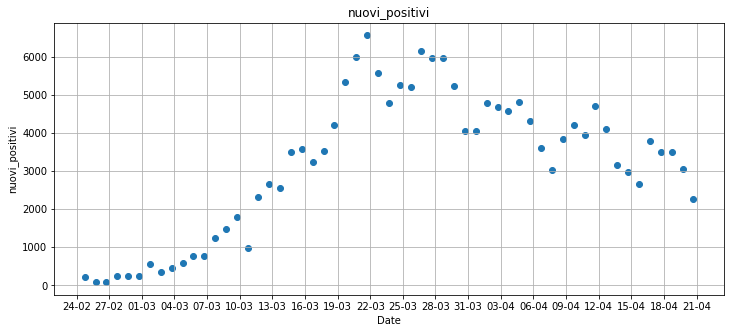

In [70]:
variable = 'nuovi_positivi'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

There is a recurrent pattern in the plot above, which is given by the anomalies occurring just after every weekend: it seems that the epidemic slows down on Mondays and Tuesdays. This is caused by the fact that during weekends (and public holidays in general such as Easter Monday) a considerably smaller number of swabs is processed.

### Correcting biases 
A possible methodology for correcting this systematic bias consists in the calculation of the moving average, which is normally used to analyze time-series by calculating averages of different subsets of the complete dataset, in our case 7 days.
The first moving average is calculated by averaging the first subset of 7 days, and then the subset is changed by moving forward to the next fixed subset, and so on. In general, the moving average smoothens the data, and it reduces anomalies like our weekend bias.

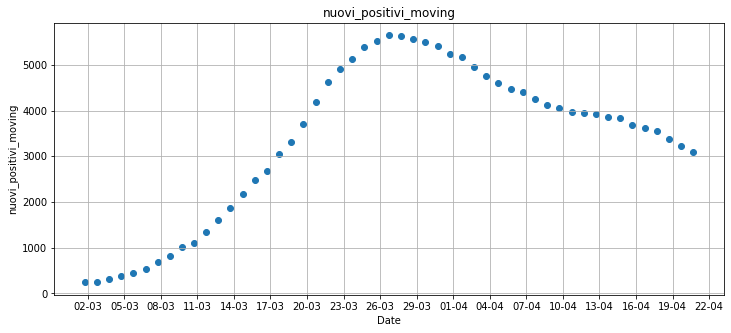

In [72]:
rolling_average_days = 7
data['nuovi_positivi_moving'] = data['nuovi_positivi'].rolling(window=rolling_average_days).mean()
variable = 'nuovi_positivi_moving'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

The chart above represents the trend of new cases averaged over a 7-days period, masking out weekend anomalies. Nevertheless, the effect of the daily number of swabs tested every day is not fully compensated yet. Clearly, the number of positive cases is strictly correlated with the quantity of tests performed. Let's take a look to the trend of daily tests performed in Italy (tamponi).

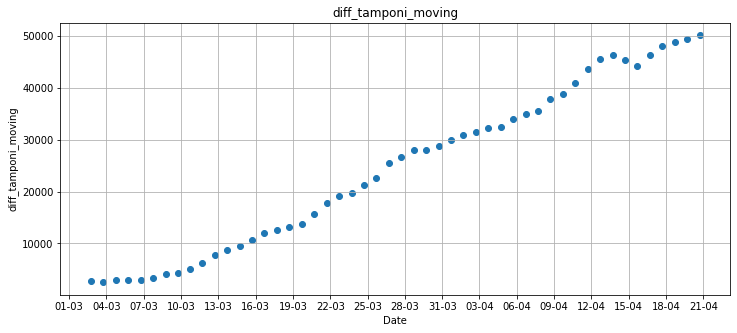

In [73]:
data['diff_tamponi_moving'] = data['tamponi'].diff().rolling(window=rolling_average_days).mean()
variable = 'diff_tamponi_moving'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

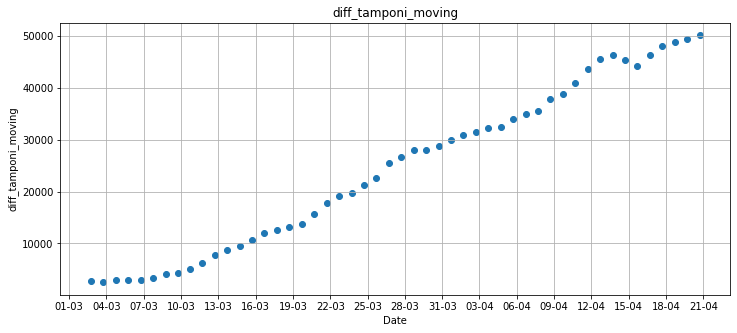

In [74]:
data['diff_tamponi_moving'] = data['tamponi'].diff().rolling(window=rolling_average_days).mean()

variable = 'diff_tamponi_moving'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

Our doubts have been confirmed: at the end our time series, the number of daily swabs is about 20 times higher than the beginning, therefore the variable nuovi_positivi is suffering from this important bias. In order to find a more representing trend, we now calculate the percentage of new positive over the total daily tests, and we inspect the variation over time.

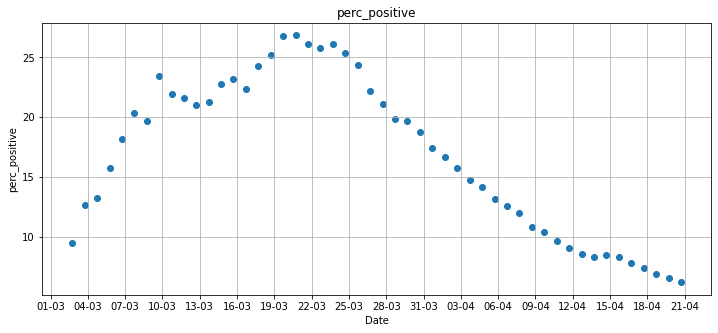

In [75]:
data['perc_positive'] = ((data['nuovi_positivi_moving'])/(data['diff_tamponi_moving'])*100)
variable = 'perc_positive'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

The derived variable perc_positive provides a more reliable representation of the epidemic progression, since it fixes the two systematic biases identified before: weekend fluctuations and overall number of tests. Unfortunately, there are still several unconsidered factors that undermines the validity of this analysis. Just to mention some of these: testing procedures have changed considerably over time, ranging from testing only severe symptomatic patients to mass testing of entire populations in specific districts, and the swabs methodology varies region by region. Moreover, data on new positive cases can refer to tests conducted in previous days, from 1 up to 7 days before. And just to make things even more complicated, some patients can also be tested multiple times, and there is no way to detect this from our dataset. For those and other reasons, perc_positive is not yet the variable we need for modeling the epidemic trend, and ultimately for forecasting its evolution.
There are other important fields that we should further inspect: in particular, let's take a closer look to terapia_intensiva and diff_deceduti ( intensive care and daily deaths, respectively).

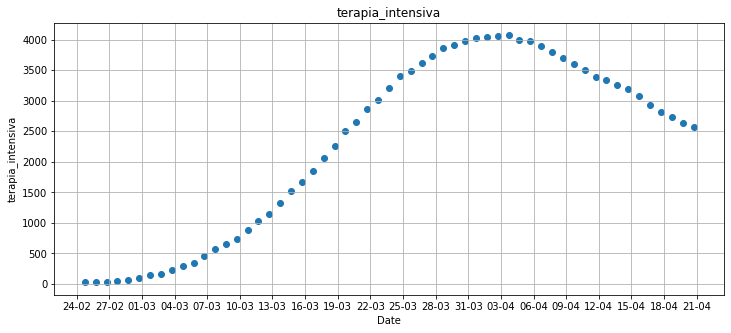

In [76]:
variable = 'terapia_intensiva'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

As showed in the chart above, the number of patients currently in intensive care seems to follow a more regular trend. In fact, it refers to an easily measurable information which doesn't suffer from sampling methodology or weekly fluctuations. Surely it is not perfect, since it can also be prone of underestimation, mostly during the acute peak of the crisis where the health system was stressed and hospitals saturated. But after that critical phase it should reflect pretty well the number of patients that are affected most severely by the virus. However, probably we are still missing something: are we sure that a decreasing number of intensive cares always corresponds to an improvement of the situation? In fact, it could be that this number is lowering as a consequence of an increasing number of daily deaths.

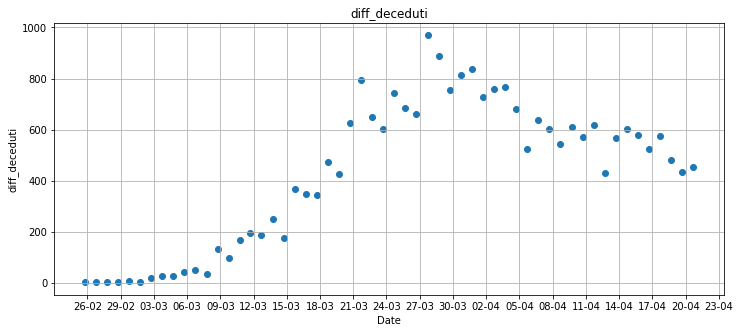

In [77]:
variable = 'diff_deceduti'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

The above charts shows that daily deaths have been increasing until march 28th, and then it started decreasing at a slower pace. 
### Creating derived variable for the model
The main assumption of this paper is that the combined value of intensive care and daily deaths can be a reliable variable for estimating the current epidemic progression, and for modeling future trends. Let's create a new field gravi_deceduti, calculate the sum of patients in severe distress with daily deaths, and plot the resulting values.

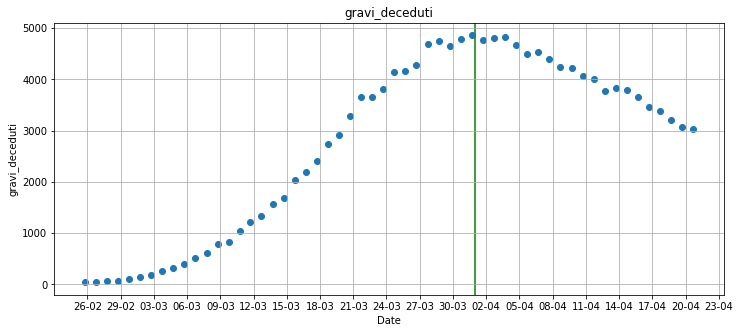

In [78]:
data['gravi_deceduti'] = data['diff_deceduti'] + data['terapia_intensiva']
variable = 'gravi_deceduti'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
ax.axvline(datetime(2020, 4, 1), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()


We explained how both terapia_intensiva and diff_deceduti do not suffer from major systemic bias, and how the latter compensates the former in case of increase of daily deaths. The combination of the two variables can now be used for modeling the trend of the epidemic in Italy, since this derived number suffers from fewer systematic bias. We added a green line on the chart in order to highlight the day the peak, which is the point where the descending trend has started. 
### Modeling the epidemic trend
We now can build a Linear Regression model and train it with the data of gravi_decedutistarting from that date, April 1st.
Linear Regression is one of the most popular classical machine learning algorithms for supervised learning. This algorithm is relatively easy to implement and works well when the relationship to between covariates and response variable is known to be linear (in our case: date VS gravi_deceduti). A clear disadvantage is that Linear Regression over simplifies many real world problems. 
The code below is an adaptation of some parts of the work done by Angelica Lo Duca on March 31st, in her attempt of modeling the epidemic using the number of positive cases.
First we import linear_model from sklearn module.  Then we exclude from X and y all data for the period before the epidemic peak registered on April 1st, and we fit the LinearRegression model with X and y. Finally, we evaluate the model by running the function score() , which returns the coefficient of determination R² of the prediction (the proportion of the variance in the dependent variable that is predictable from the independent variable). R² will give some information about the goodness of fit of a model. In regression, the R² coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R² of 1 indicates that the regression predictions perfectly fit the data, therefore the closer the value gets to 1, the more we can trust our model.

In [79]:
import numpy as np
from sklearn import linear_model
# prepare the lists for the model
X = date_format
y = data['gravi_deceduti'].tolist()[1:]
# date format is not suitable for modeling, let's transform the date into incrementals number starting from April 1st
starting_date = 37  # April 1st is the 37th day of the series
day_numbers = []
for i in range(1, len(X)):
    day_numbers.append([i])
X = day_numbers
# # let's train our model only with data after the peak
X = X[starting_date:]
y = y[starting_date:]
# Instantiate Linear Regression
linear_regr = linear_model.LinearRegression()
# Train the model using the training sets
linear_regr.fit(X, y)
print ("Linear Regression Model Score: %s" % (linear_regr.score(X, y)))

Linear Regression Model Score: 0.9883718211658477


### Predict future trend
Now that we have fitted the model and evaluated positively its R² score, we are ready for predicting the evolution of gravi_deceduti in the future. For doing this, we call the function predict()and we keep track of the the maximum error done by the model with the function max_error(). Using that value, we will create two lines that will depict the tolerance buffer, with both minimum and maximum errors of the model's predictions.

In [80]:
# Predict future trend
from sklearn.metrics import max_error
import math
y_pred = linear_regr.predict(X)
error = max_error(y, y_pred)

The model is now ready for predicting gravi_deceduti for next days. We define a variable X_test, which contains both past and future days. We also create the variable future_days containing the number of days for which we want to estimate the epidemic trend. Then we apply our model to X_test.

In [81]:
X_test = []
future_days = 55
for i in range(starting_date, starting_date + future_days):
    X_test.append([i])
y_pred_linear = linear_regr.predict(X_test)

The variable y_pred_linear contains the predicted gravi_deceduti for next 55 days. In order to consider the errors made by the model, we define y_pred_max and y_pred_min containing the y_pred + error and y_pred - error, respectively.

In [82]:
y_pred_max = []
y_pred_min = []
for i in range(0, len(y_pred_linear)):
    y_pred_max.append(y_pred_linear[i] + error)
    y_pred_min.append(y_pred_linear[i] - error)

### Plot the forecast
We have three output variables ready to be displayed on a chart: y_pred, y_pred_max and y_pred_min, containing the predictions, the maximum error and minimum error, respectively. In order to make the plot more appealing, we should convert numbers (represented by the X_test variable) to dates.

In [83]:
# convert date of the epidemic peak into datetime format
from datetime import datetime, timedelta
date_zero = datetime.strptime(data['data'][starting_date], '%Y-%m-%dT%H:%M:%S')
# creating x_ticks for making the plot more appealing
date_prev = []
x_ticks = []
step = 5
data_curr = date_zero
x_current = starting_date
n = int(future_days / step)
for i in range(0, n):
    date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
    x_ticks.append(x_current)
    data_curr = data_curr + timedelta(days=step)
    x_current = x_current + step

Now we can plot the known data together with the forecast and the error lines

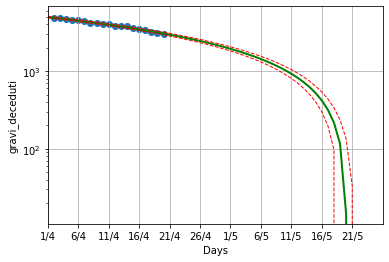

In [84]:
# plot known data
plt.grid()
plt.scatter(X, y)
# plot linear regression prediction
plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
# plot maximum error
plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
#plot minimum error
plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.xlim(starting_date, starting_date + future_days)
plt.xticks(x_ticks, date_prev)
plt.ylabel('gravi_deceduti')
plt.yscale("log")
plt.savefig("prediction.png")
plt.show()

Now, let's calculate the dates of expected end of the epidemic using a couple of linear algebra operations. It is given by the intersections between our lines and the X axis.

In [85]:
import math
def n_to_date(n):
    #it converts a number to a date, considering starting from starting_date
    return (date_zero + timedelta(days=n-starting_date)).strftime('%d/%m/%Y')
def build_line(x1,y1,x2,y2):
    m = float(y2 - y1)/(x2-x1)
    q = y1 - (m*x1)
    return [m,q]

data_zero = round(- linear_regr.intercept_ / linear_regr.coef_[0])

line_max = build_line(X_test[0][0], y_pred_max[0], X_test[1][0], y_pred_max[1])
data_zero_max = math.ceil(- line_max[1] / line_max[0])
data_zero_max = n_to_date(data_zero_max)

line_min = build_line(X_test[0][0], y_pred_min[0], X_test[1][0], y_pred_min[1])
data_zero_min = math.floor(- line_min[1] / line_min[0])
data_zero_min = n_to_date(data_zero_min)
print ()
print ("Zero intensive cares and deaths expected between %s and %s" % (data_zero_max, data_zero_min))


Zero intensive cares and deaths expected between 22/05/2020 and 18/05/2020


### Regional trends
The above analysis is treating Italian COVID-19 on a national basis, but it is known that regions of Lombardia, Piemonte, Veneto and Emilia-Romagna have been affected more severely then the others. In order to quantify this, we can inspect the regional COVID-19 dataset provided by the Civil Protection, and calculate the proportion of the deaths registered in those regions (we call them Zone 1)

In [86]:
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
zone1_df = data[data.denominazione_regione.isin(['Piemonte','Emilia-Romagna','Veneto','Lombardia'])]
zone1_df['deceduti'].sum()
print("Zone 1 accounts for %s percent of the total deaths" % (round(zone1_df['deceduti'].sum() / data['deceduti'].sum() * 100,2)))

Zone 1 accounts for 80.74 percent of the total deaths


If just those 4 regions (out of 20) account for more than 80% of the total deaths, having a single model that predicts the trend for the whole country is a major oversimplification. 
Let's take a look to regional trends of both perc_positive and gravi_deceduti, for a sample of regions.

Creating regional charts for perc_positive


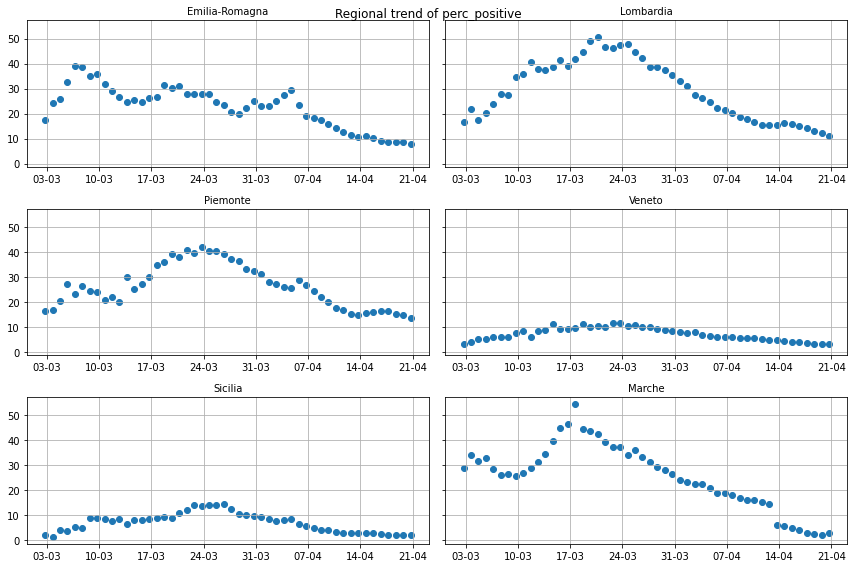

Creating regional charts for gravi_deceduti


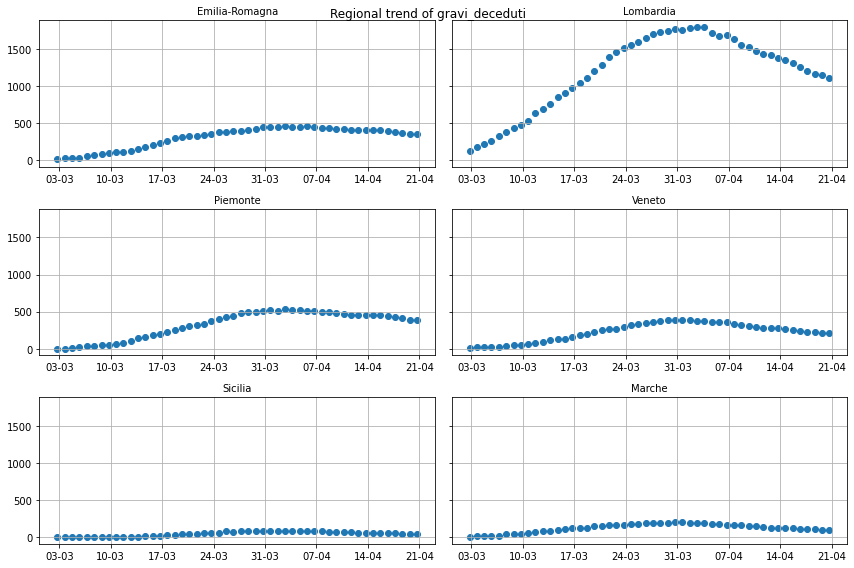

In [87]:
regions_dict = {'Emilia-Romagna': 8, 'Lombardia' : 3, 'Piemonte': 1,'Veneto': 5, 'Sicilia' : 19, "Marche" : 11}

rolling_average_days = 7

regional_data_list = []

for region_name, region_code in regions_dict.items():
    is_region = data['codice_regione'] == region_code
    data_region = data[is_region].copy()
    date = data_region['data']
    date_format = [pd.to_datetime(d) for d in date]
    data_region['nuovi_positivi'] = data_region['nuovi_positivi'].rolling(window=rolling_average_days).mean()
    data_region['diff_deceduti'] = data_region['deceduti'].diff().rolling(window=rolling_average_days).mean()
    data_region['tamponi_giornalieri'] = data_region['tamponi'].diff().rolling(window=rolling_average_days).mean()
    data_region['perc_positive'] = ((data_region['nuovi_positivi'])/(data_region['tamponi_giornalieri'])*100)
    data_region['gravi_deceduti'] =  data_region['diff_deceduti'] + data_region['terapia_intensiva']
    regional_data_list.append(data_region)

list_of_variables = ['perc_positive', 'gravi_deceduti']

for variable in list_of_variables:
    print("Creating regional charts for " + variable)
    fig, axs = plt.subplots(3, 2, sharey=True,figsize=(12, 8))
    fig.suptitle('Regional trend of ' + variable,fontsize = 'large')
    date_form = DateFormatter("%d-%m")
    counter = 0
    for ax in axs.flat:
        ax.scatter(date_format, regional_data_list[counter][variable])
        ax.set_title(regional_data_list[counter]['denominazione_regione'].iloc[0], fontsize='medium')
        ax.xaxis.set_major_formatter(date_form)
        # Ensure a major tick for each week using (interval=1)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.grid()
        counter +=1
    fig.tight_layout()
    fig.savefig('Regional trend of %s' + variable + '.png')
    plt.show()

As shown in the charts above, the situation varies considerably from region to region.

For each region a different model should be applied, in order to better understand the epidemic trends in the different areas of the country. Given that the Civil Protection provides data also on a provincial basis, it would be possible to model the situation even better than this. 
### Conclusions
Our model tells us that the COVID-19 epidemic will end in Italy between __19th and 22nd May 2022__, if the current trend is maintained over time. 
Regional differences apart, we have to consider that any new external factor can change the effective trend of the epidemic. The current model can not take into account unexpected changes in the system, such as the gradual loosening of lockdown restrictions, or the effects of warmer temperature over the virus spread.
In my next article I will create different models for every region separately, and I will upload the code on GitHub.